<a href="https://colab.research.google.com/github/Eungyum/scikit-learn_study/blob/main/4_5_%EB%B3%80%EC%88%98_%EC%84%A0%ED%83%9D_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98_SBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SBS(Sequential Backward Selection) 알고리즘

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
class SBS():
    def __init__(self, estimator, k_features,
                scoring=accuracy_score,
                test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator=clone(estimator)
        self.k_features=k_features
        self.test_size=test_size
        self.random_state=random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores =[]
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])

        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:,indices], y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)

In [ ]:
sbs = SBS(knn, k_features=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data')
df_wine.columns = ['Class label','Alcohole','Mlic acid','Ash','Alcalinity of ash','Magnesium',
                  'Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins',
                  'Color intensity','Hue','0D280/0D315 of diluted wines','Proline']
X = df_wine.iloc[:,1:].values # 특성은 0을 제외한 모든 열
y = df_wine.iloc[:,0].values # 타겟은 0열

X_train, X_test, y_train, y_test =\
train_test_split(X, y,
                 test_size=0.3,
                 random_state=0,
                 stratify=y)
sc = StandardScaler()
sc.fit(X_train) # 훈련 데이터셋의 샘플 평균과 표준편차를 계산
X_train_std = sc.transform(X_train) # transform 메서드에서 계산된 샘플 평균과 표준편차로 표준화
X_test_std = sc.transform(X_test)

In [ ]:
sbs.fit(X_train_std, y_train)

In [ ]:
k_feat = [len(k) for k in sbs.subsets_]

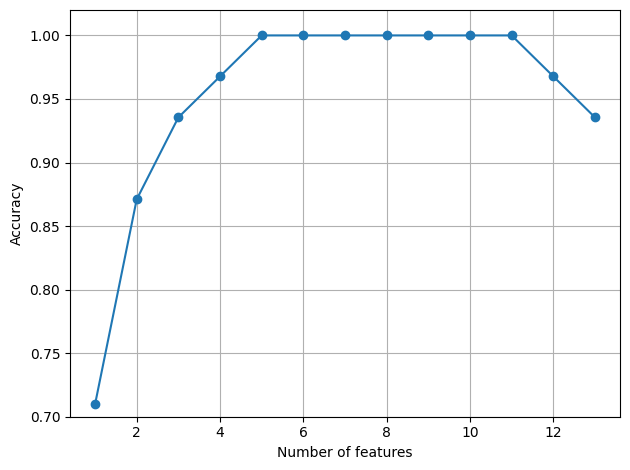

In [ ]:
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
k4 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k4])

Index(['Alcohole', '0D280/0D315 of diluted wines', 'Proline'], dtype='object')
